In [2]:
import numpy as np
import h5py
import scipy
import matplotlib.pyplot as plt
import scienceplots
import tensorstore as ts

plt.style.use(['nature', 'no-latex'])

In [ ]:
from zapbench import constants

constants.DATASET_CONFIGS['240930_traces']

In [ ]:
ds_traces = ts.open({
    'open': True,
    'driver': 'zarr3',
    'kvstore': 'gs://zapbench-release/volumes/20240930/traces'
}).result()
x_zap = ds_traces.read().result()

Normalize and compare datasets

In [ ]:
zap_avg = np.mean(x_zap)
zap_std = np.std(x_zap)

In [ ]:
zap_avg, zap_std

In [8]:
def fill_gaps(states, max_interval):
    result = states.copy()
    current = 0
    i = 0
    while i < len(states):
        if states[i] != 0:
            current = states[i]
            i += 1
        else:
            start = i
            while i < len(states) and states[i] == 0:
                i += 1
            if i - start <= max_interval and current != 0:
                for j in range(start, i):
                    result[j] = current
    return result


def fill_start(x):
  i = 0
  pt = 0
  while not pt:
    pt = x[i]
    i += 1
  x[:i-1] = x[i]
  return x


def get_condition_intervals(x, condition_ix_list):
    interval_bounds_by_condition = []
    for condition_ix in condition_ix_list:
        mask = (x == condition_ix).astype(int)
        mask_diff = np.diff(mask)
        starts = np.where(mask_diff == 1)[0] + 1
        ends = np.where(mask_diff == -1)[0]
        if mask[0] == 1:
            starts = np.insert(starts, 0, 0)
        if mask[-1] == 1:
            ends = np.append(ends, len(mask)-1)
        interval_bounds = tuple((int(s), int(e)) for s, e in zip(starts, ends))
        interval_bounds_by_condition.append(interval_bounds)
    interval_bounds_by_condition = tuple(interval_bounds_by_condition)
    return interval_bounds_by_condition


def get_condition_cfg(data_struct):
  stim_full = data_struct['stim_full'].ravel()

  if 'stimset' in data_struct.dtype.fields:
    stim_full_harmonized = np.zeros_like(stim_full)
    n_conditions = data_struct['stimset'].shape[-1]
    for i in range(n_conditions):
      name, pattern = data_struct['stimset'][0, i]['name'][0], np.unique(data_struct['stimset'][0, i]['pattern'])
      indices = np.where(np.isin(data_struct['stim_full'].ravel(), pattern[pattern != 3]))[0]
      stim_full_harmonized[indices] = condition_map[name]

    x = fill_gaps(stim_full_harmonized, 100)
    x = fill_start(x)
    x = x.astype(int)
    condition_ix_list = np.unique(x)
    condition_intervals = get_condition_intervals(x, condition_ix_list)

  else:
    i_condition = condition_map[data_struct['timelists_names'][0, 0][0]]
    condition_ix_list = [i_condition]
    condition_intervals = (0, len(stim_full)-1,)
    stim_full[len(stim_full)-1]

  conditions_train = tuple(int(ix) for ix in condition_ix_list)
  return conditions_train, condition_intervals


def save_ts(x: np.ndarray, subject_id: str, data_type: str) -> None:
  """Save np array to ts."""
  spec = {
      'driver': 'zarr3',
      'kvstore': {'driver': 'file', 'path': f'{PATH_STORE}/subject_{subject_id}_{data_type}.zarr'},
      'metadata': {
          'shape': [*x.shape],
          'chunk_grid': {'name': 'regular', 'configuration': {'chunk_shape': [512, 512]}},
          'chunk_key_encoding': {'name': 'default'},
          'codecs': [{'name': 'bytes', 'configuration': {'endian': 'little'}}],
          'data_type': 'float32',
          'fill_value': 0.0
      }
  }
  ds = ts.open(spec, create=True).result()
  ds[...] = x


def save_janelia(subject_id: str) -> None:

  h5_path = f"{PATH}/subject_{subject_id:02d}"
  x = h5py.File(f"{h5_path}/TimeSeries.h5", "r")
  x = np.array(x['CellResp']).astype(np.float32)
  jan_avg, jan_std = np.mean(x), np.std(x)
  x_n = ((x - jan_avg)/jan_std) * zap_std + zap_avg
  x_n = np.clip(x_n, -0.25, 3.0)
  n_t, n_neurons = x_n.shape
  # save_ts(x_n, subject_id, "traces")

  mat_path = f"{PATH}/subject_{subject_id:02d}/data_full.mat"
  data_struct = scipy.io.loadmat(mat_path)['data'][0, 0]

  # TODO: something is off, n_neurons here does not match n_neurons in traces
  # coordinates = data_struct['CellXYZ'].astype(np.float32)
  # assert coordinates.shape == (n_neurons, 3)
  # save_ts(coordinates, subject_id, "coordinates")

  stimuli = data_struct['stim_full'].ravel().astype(np.float32)
  stimuli = np.eye(n_stimulus_encodings, dtype=np.float32)[stimuli.astype(int)]
  assert stimuli.shape == (n_t, n_stimulus_encodings)
  # save_ts(stimuli, subject_id, "stimuli")

  behavioral_covariates = data_struct['Behavior_full'].T.astype(np.float32)
  assert behavioral_covariates.shape == (n_t, 5)
  # save_ts(behavioral_covariates, subject_id, "behavioral_covariates")

  conditions, condition_intervals = get_condition_cfg(data_struct)
  condition_names = tuple(all_condition_names[i] for i in conditions)
  if len(conditions) == 1:
    conditions_train, conditions_holdout = conditions, ()
  else:
    conditions_train, conditions_holdout = conditions[:-1], (conditions[-1],)

  print(condition_names)
  spec = get_spec(subject_id, condition_intervals, condition_names, conditions_train, conditions_holdout, n_t, n_neurons)
  return spec


def create_config():
  pass


def format_ax(ax):
  for spine in ax.spines.values():
    spine.set_linewidth(1.2)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.tick_params(which='minor', length=0)
  ax.tick_params(axis='both', labelsize=12)
  ax.tick_params(axis='x', which='both', top=False, direction="out", width=1.2, length=4)
  ax.tick_params(axis='y', which='both', left=False, right=False, direction="out", width=1.2)

In [ ]:
def get_spec(subject_id: int, condition_intervals, condition_names, conditions_train, conditions_holdout, n_t, n_neurons):
  spec = {
      'condition_intervals': condition_intervals,
      'condition_names': condition_names,
      'conditions_train': conditions_train,
      'conditions_holdout': conditions_holdout,
      'timeseries_name': f'subject_{subject_id:02d}',
      'covariate_series_name': f'subject_{subject_id:02d}_stimuli_features',
      'specs': {
          f'subject_{subject_id:02d}': {
              'kvstore': '',
              'driver': 'zarr3',
              'transform': {
                  'input_exclusive_max': [[n_t], n_neurons],
                  'input_inclusive_min': [0, 0],
                  'input_labels': ['t', 'f'],
              },
          },
      },
      'covariate_specs': {
          f'subject_{subject_id:02d}_stimuli_features': {
              'kvstore': '',
              'driver': 'zarr3',
              'transform': {
                  'input_exclusive_max': [[n_t], n_neurons],
                  'input_inclusive_min': [0, 0],
                  'input_labels': ['t', 'f'],
              },
          },
          f'subject_{subject_id:02d}_behavioral_covariates': {
              'kvstore': '',
              'driver': 'zarr3',
              'transform': {
                  'input_exclusive_max': [[n_t], n_neurons],
                  'input_inclusive_min': [0, 0],
                  'input_labels': ['t', 'f'],
              },
          },
      },
      'min_max_values': {
          '240930_traces': (-0.25, 3.0),
      },
  }
  return spec

In [6]:
# PATH_STORE = "/Users/s/vault/neural_data/janelia/ts_files"
PATH = "/Users/s/vault/neural_data/janelia"
n_stimulus_encodings = 16
all_condition_names = ['spontaneous', 'taxis', 'dark-taxis', 'dark', 'opt_response', 'looming']
condition_map = dict()
condition_map['Spontaneous'] = 0
condition_map['phototaxis'] = 1
condition_map['PT'] = 1
condition_map['16 permut: B/W/phototaxis*2'] = 2
condition_map['DF'] = 3
condition_map['OMR'] = 4
condition_map['Looming'] = 5


In [ ]:
PATH = "/Users/sebastianvoigtlaender/vault/neural_data/janelia"
subject_id_list = [1, 2, 3, 4, 5, 6, 7, 12, 13, 14, 15, 16, 17]

for subject_id in subject_id_list:
  print('SUBJECT', subject_id)
  h5_path = f"{PATH}/subject_{subject_id:02d}/"
  x_jan = h5py.File(f"{h5_path}TimeSeries.h5", "r")
  x_jan = np.array(x_jan['CellResp']).astype(np.float32)

  jan_avg, jan_std = np.mean(x_jan), np.std(x_jan)
  x_jan_n = ((x_jan - jan_avg)/jan_std) * zap_std + zap_avg
  x_jan_n = np.clip(x_jan_n, -0.25, 3.0)

  fig, ax = plt.subplots(1, 1, figsize=(6, 1), sharex=True, dpi=200)
  ax.hist(x_zap.ravel()[::1000], bins=100, density=True, alpha=0.4);
  ax.hist(x_jan_n.ravel()[::1000], bins=100, density=True, alpha=0.4);
  ax.set_yscale('log')
  format_ax(ax)
  ax.set_xlim(-0.25, 4)
  plt.show()

  print(len(np.where(x_jan < mini)[1]), len(np.where(x_jan > maxi)[1]))

SUBJECT 5
(2,)



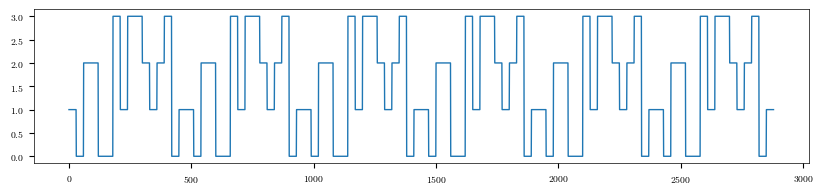

SUBJECT 6
(1,)



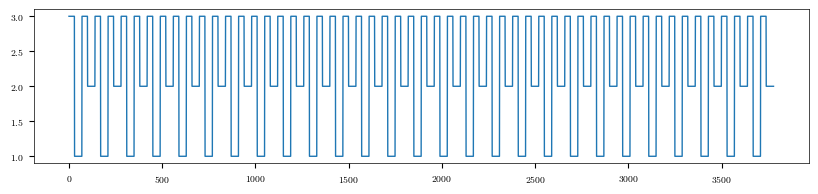

SUBJECT 14
(2,)



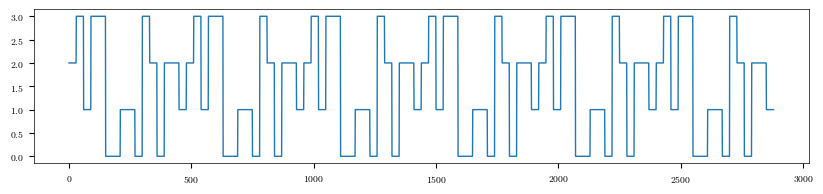

SUBJECT 17
[0 1 3 4 5]


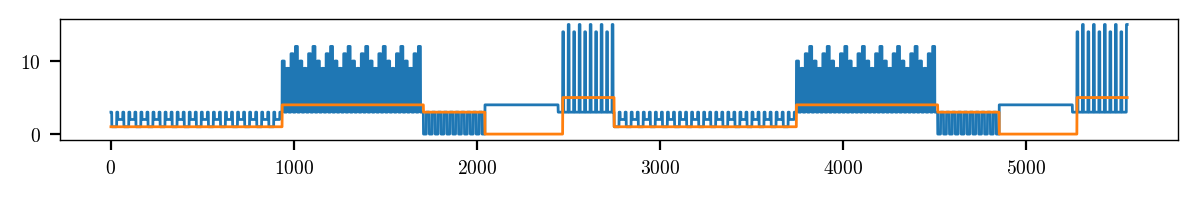

In [11]:
PATH = "/Users/s/vault/neural_data/janelia"
subject_id_list = [5, 6, 14, 17]
n_stimulus_encodings = 16

for subject_id in subject_id_list:
  print('SUBJECT', subject_id)
  mat_path = f"{PATH}/subject_{subject_id:02d}/data_full.mat"
  mat_data = scipy.io.loadmat(mat_path)
  data_struct = mat_data['data'][0, 0]
  stim_full = data_struct['stim_full'].ravel()
  stim_full_onehot = np.eye(n_stimulus_encodings, dtype=np.float32)[stim_full.astype(int)]

  if 'stimset' in data_struct.dtype.fields:
    stim_full_harmonized = np.zeros_like(stim_full)
    n_conditions = data_struct['stimset'].shape[-1]
    for i in range(n_conditions):
      name, pattern = data_struct['stimset'][0, i]['name'][0], np.unique(data_struct['stimset'][0, i]['pattern'])
      indices = np.where(np.isin(data_struct['stim_full'].ravel(), pattern[pattern != 3]))[0]
      stim_full_harmonized[indices] = condition_map[name]

    result = fill_gaps(stim_full_harmonized, 100)
    result = fill_start(result)
    result = result.astype(int)
    print(np.unique(result))

    fig, axs = plt.subplots(1, 1, figsize=(6, 1), sharex=True, dpi=200)
    axs.plot(stim_full)
    axs.plot(result)
    plt.tight_layout()
    plt.show()

  else:
    i_condition = condition_map[data_struct['timelists_names'][0, 0][0]]
    print((i_condition,))
    print()
    plt.figure(figsize=(10, 2))
    plt.plot(stim_full)
    plt.show()

Try loading

In [ ]:
PATH_STORE = "/Users/sebastianvoigtlaender/vault/neural_data/janelia/ts_files"
data_types = ["traces", "behavioral_covariates"]
subject_id = 17

for data_type in data_types:

  ds_janelia = ts.open({
      'open': True,
      'driver': 'zarr3',
      'kvstore': f'file://{PATH_STORE}/subject_{subject_id:02d}_{data_type}.zarr'
  }).result()

  print(ds_janelia.shape)